<a href="https://colab.research.google.com/github/joshualewin6/Colab-Notebook/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [200]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)

In [201]:
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [202]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [203]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

In [204]:
with pm.Model(coords=aa_coords) as cs_hst_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu=10)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu=10)
    μ_nu = pm.Exponential('μ_nu', lam=1/10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = μ_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10,
                      nu = 10,
                      dims = "aa")

    ν = pm.Exponential('ν',
                      lam=1/10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_hst = pm.sample()

Output()

Output()

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

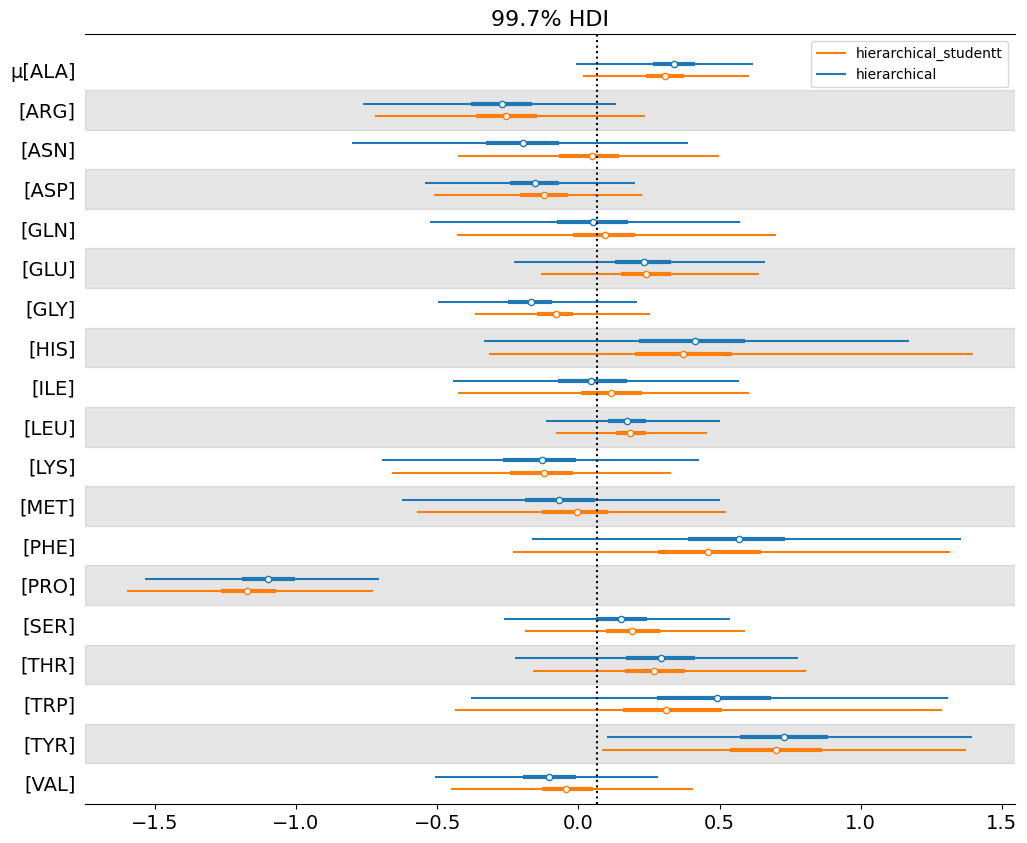

In [205]:
axes = az.plot_forest([idata_cs_h, idata_cs_hst], kind="forestplot",
                      model_names=['hierarchical', 'hierarchical_studentt'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

I would say this is a better model, it seems to have an overall trend of some shrinkage in the differences between theoretical and experimental results, but more specifically, the overall mean is now clearly within TYR's confidence interval, meaning one more amino acid can reasonably be predicted experimentally with our current model.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [206]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [207]:
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [208]:
with pm.Model(coords = sccr_coords) as sccr_model:


    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha=2, beta=20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

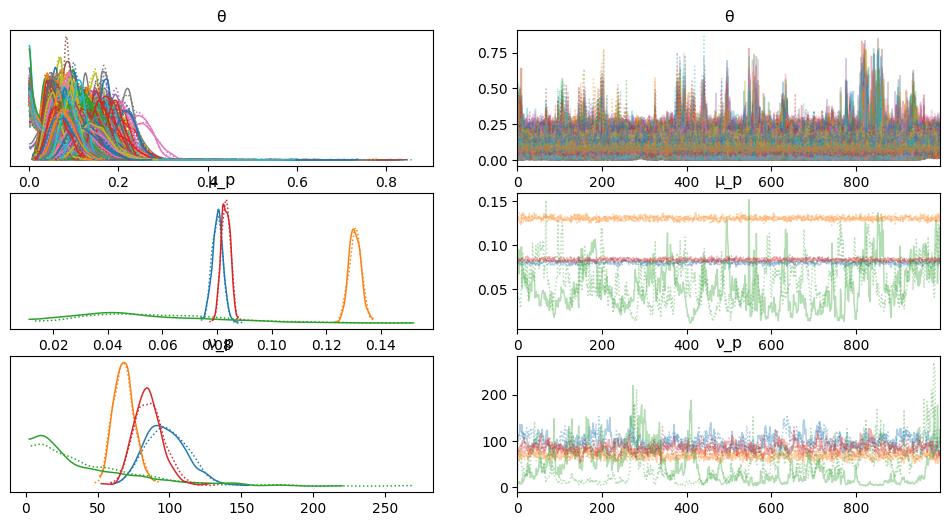

In [209]:
az.plot_trace(idata_sccr)

In [210]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.002 1.006 1.002 1.001 ... 1.0 1.002 1.0
    μ_p      (pos) float64 32B 1.003 1.003 1.024 1.001
    ν_p      (pos) float64 32B 1.001 1.002 1.28 1.012

This actually appears moderately better than the hierarchical model, with the DF position showing sigificant improvement in its chains for the kurtosis and the FW now elevating to a definitively good Markov chain, with rhats of 1 and 1.001. The MF position shows little change. Meanwhile, the GK position is still a mess, but with massive improvement in the mean, going from an rhat of greater than 1.2 to less than 1.05, while the kurtosis went from about 1.09 to about 1.18, becoming bad. I'm inclined to say the non-hierarchical model is marginally better than the hierarchical one, but considering there are mixed signals, I'll say that neither is definitively better overall.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

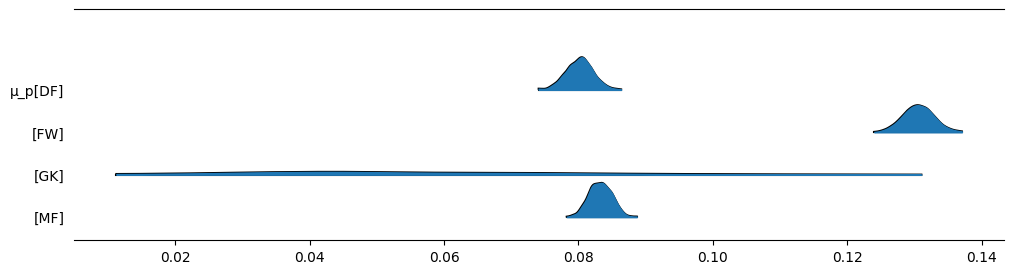

In [211]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

As evidenced by running the rhats, there's not a ton of change. DF, FW, and MF have decent predictions, while the model still as no idea what's going on with GK position.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [212]:
url_sccr_ngk = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data_ngk = pd.read_csv(url_sccr_ngk)
sccr_data_ngk = sccr_data_ngk.query("position != 'GK'")
sccr_pos_ngk=sccr_data_ngk["position"].astype('category')
sccr_data_ngk = sccr_data_ngk.drop(["position"],axis=1)
sccr_data_ngk.insert(loc=1,column='position',value=sccr_pos_ngk)
pos_idx_ngk = sccr_data_ngk.position.cat.codes.values
pos_codes_ngk = sccr_data_ngk.position.cat.categories
sccr_coords_ngk = {"posit": pos_codes_ngk}

In [213]:
with pm.Model(coords = sccr_coords_ngk) as sccr_model_ngk:
    # Hyper parameters
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "posit")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="posit")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_ngk.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_ngk.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_ngk = pm.sample(target_accept = 0.95)

ValueError: Incompatible Elemwise input shapes [(2517,), (2682,)]

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

It was easier for pymc to process the no GK model, since the bad rhat values were eliminated there weren't any wildly unhealthy chains. We do lose a small amount of information from the lack of GKs, especially since they averaged fewer goals per shot, which should influence the data. However, since the goals per shot for different goalies varied so wildly, the hyperpriors were negatively influencing the other positions, yielding a worse model for DF, MF, and FW. Removing GK added plenty of precision and allowed the hyperpriors to better inform the positional priors, and by extension the posterior predictive means.